<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [2]:
img_per_class = 20
# Load the image paths
file_paths = glob.glob('./MVTec AD Dataset/capsule/test/*/*.png')
print(file_paths)
file_paths = sorted([path for path in file_paths if path.split('\\')[-1] in [f'{i:03}.png' for i in range(img_per_class)]])
print(len(file_paths)) 

['./MVTec AD Dataset/capsule/test\\crack\\000.png', './MVTec AD Dataset/capsule/test\\crack\\001.png', './MVTec AD Dataset/capsule/test\\crack\\002.png', './MVTec AD Dataset/capsule/test\\crack\\003.png', './MVTec AD Dataset/capsule/test\\crack\\004.png', './MVTec AD Dataset/capsule/test\\crack\\005.png', './MVTec AD Dataset/capsule/test\\crack\\006.png', './MVTec AD Dataset/capsule/test\\crack\\007.png', './MVTec AD Dataset/capsule/test\\crack\\008.png', './MVTec AD Dataset/capsule/test\\crack\\009.png', './MVTec AD Dataset/capsule/test\\crack\\010.png', './MVTec AD Dataset/capsule/test\\crack\\011.png', './MVTec AD Dataset/capsule/test\\crack\\012.png', './MVTec AD Dataset/capsule/test\\crack\\013.png', './MVTec AD Dataset/capsule/test\\crack\\014.png', './MVTec AD Dataset/capsule/test\\crack\\015.png', './MVTec AD Dataset/capsule/test\\crack\\016.png', './MVTec AD Dataset/capsule/test\\crack\\017.png', './MVTec AD Dataset/capsule/test\\crack\\018.png', './MVTec AD Dataset/capsule/te

In [3]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/120 [00:00<?, ?it/s]

(120, 1000, 1000, 3)


Classes: ['crack', 'faulty_imprint', 'good', 'poke', 'scratch', 'squeeze']


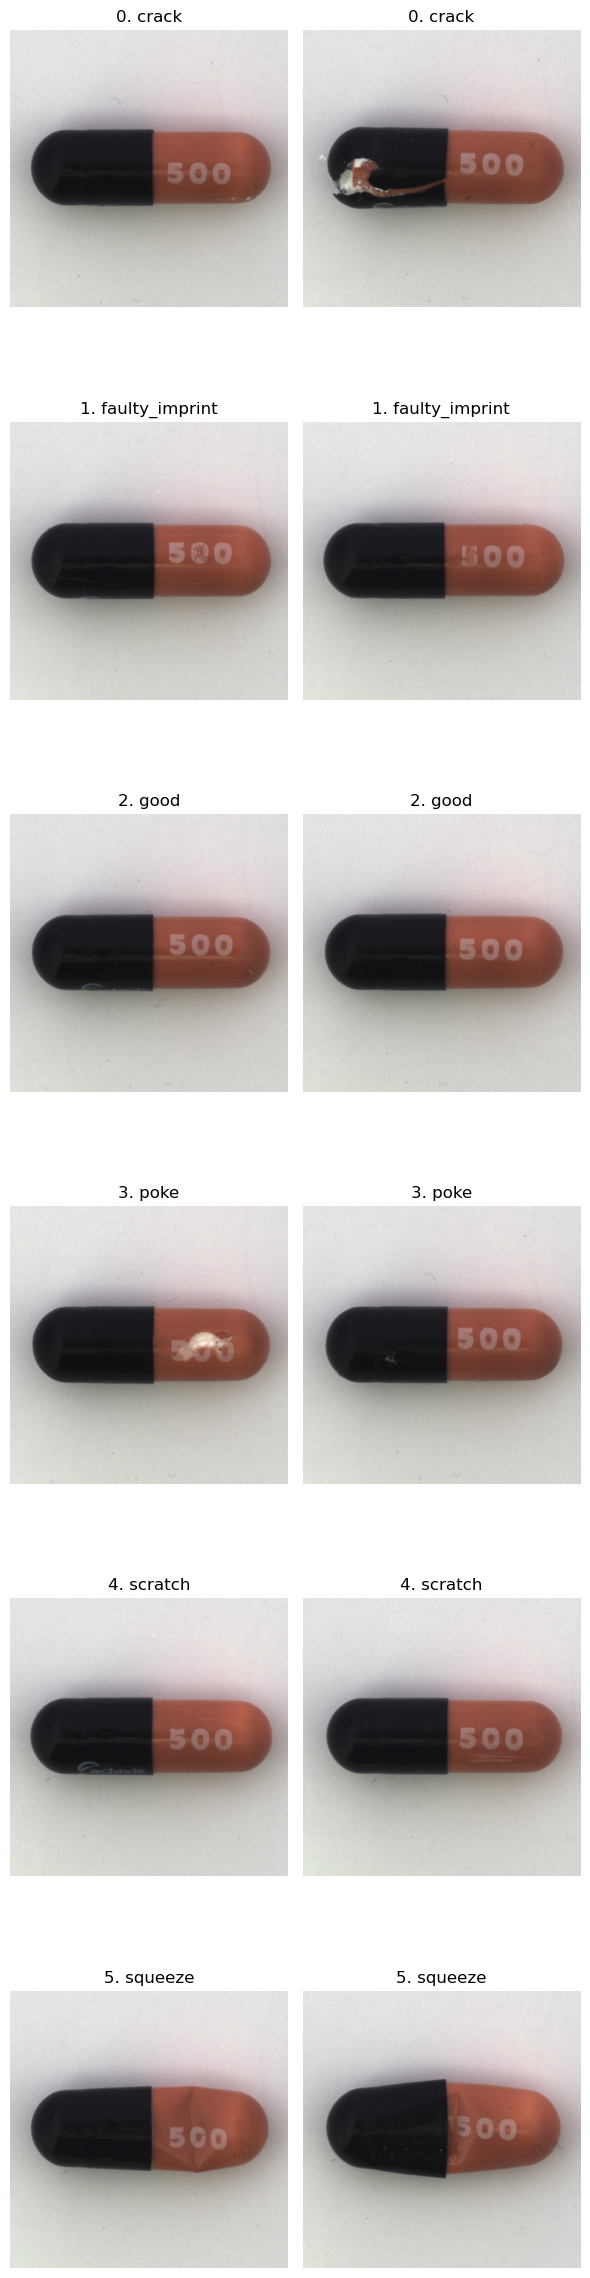

In [4]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('\\')[1] for path in file_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = len(classes)
images_per_class = img_per_class
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (96, 3, 1000, 1000)
Shape of x_val: (24, 3, 1000, 1000)
Shape of y_train: (96,)
Shape of y_val: (24,)


## B. Defining Neural Networks

In [6]:
import torch.nn as nn
from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights

model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1)

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[1].in_features  # classifier is a Sequential: [Dropout, Linear]
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

## C. Training the Neural Network

In [7]:
def train_model(x_train, y_train, x_val, y_val, model,
                batch_size=32, resize_size=(32, 32), normalize=False, epochs=200, device=None):
    import numpy as np
    from torchvision import transforms
    from torch.utils.data import DataLoader, Dataset
    from PIL import Image
    import torch
    import torch.optim as optim
    import torch.nn as nn
    from torch.optim.lr_scheduler import CosineAnnealingLR
    from tqdm.auto import tqdm

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Build normalization component if needed
    norm_components = []
    if normalize:
        # using arbitrary cifar-like mean/std; adjust as needed
        norm_components.append(transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))

    # Compose transformations for training and validation
    train_transforms = transforms.Compose(
        [
            transforms.Resize(resize_size),
            transforms.AutoAugment(),
            transforms.RandomRotation(25),
            transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ] + norm_components
    )

    val_transforms = transforms.Compose(
        [
            transforms.Resize(resize_size),
            transforms.ToTensor(),
        ] + norm_components
    )

    # Custom Dataset class
    class MyDataset(Dataset):
        def __init__(self, x, y, transform=None):
            self.x = x
            self.y = torch.from_numpy(y).long()
            self.transform = transform

        def __len__(self):
            return len(self.x)

        def __getitem__(self, idx):
            new_x = np.transpose(self.x[idx], (1, 2, 0))
            if self.transform:
                new_x = self.transform(Image.fromarray(new_x))
            return new_x, self.y[idx]

    train_dataset = MyDataset(x_train, y_train, transform=train_transforms)
    val_dataset = MyDataset(x_val, y_val, transform=val_transforms)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

    print(f'Length of train_loader: {len(train_loader)}')
    print(f'Length of val_loader: {len(val_loader)}')

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

    best_val_loss = float('inf')
    best_val_acc = -1

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(epochs)):
        # Training phase
        model.train()
        total_loss = 0.0
        train_correct = 0
        total_train_samples = 0

        for images, labels in train_loader:
            # images are already scaled to [0,1] by ToTensor
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_train_samples += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100. * train_correct / total_train_samples

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100. * correct / total

        lr_scheduler.step()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

        # print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, ' +
        #       f'Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, ' +
        #       f'Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f}, ' +
        #       f'Best Val acc: {best_val_acc:.2f}%')
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
    

    return model, (train_losses, train_accuracies, val_losses, val_accuracies, best_val_acc)

### Batch size

In [8]:
# Define hyperparameters for the experiments
hyperparams = [
    {'batch_size': 4, 'resize_size': (64, 64), 'normalize': False},
    {'batch_size': 16, 'resize_size': (64, 64), 'normalize': False},
    {'batch_size': 32, 'resize_size': (64, 64), 'normalize': False},
    {'batch_size': 64, 'resize_size': (64, 64), 'normalize': False}
]

results = []


best_val_acc_global = -1
best_model_state_dict = None
best_exp = None

for exp in hyperparams:
    print("Experiment:", exp)
    # New model with frozen parameters
    import torch.nn as nn
    from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
    new_model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1)
    for param in new_model.parameters():
        param.requires_grad = False
    num_ftrs = new_model.classifier[1].in_features  # classifier is a Sequential: [Dropout, Linear]
    new_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Train the model with the current hyperparameters
    current_epochs = exp.get('epochs', 200)
    model_result, metrics = train_model(x_train, y_train, x_val, y_val, new_model,
                                        batch_size=exp['batch_size'],
                                        resize_size=exp['resize_size'],
                                        normalize=exp['normalize'],
                                        epochs=current_epochs)
    results.append((exp, metrics))
    
    # metrics: (avg_train_loss, train_accuracy, avg_val_loss, val_accuracy, best_val_acc)
    _, _, _, _, best_val_acc = metrics
    if best_val_acc > best_val_acc_global:
        best_val_acc_global = best_val_acc
        best_exp = exp
        

# print the results of all experiments
print("\nSummary of Experiments:")
for exp, metrics in results:
    print("Hyperparameters:", exp)
    print("Results:")
    print("  avg_train_loss:", metrics[0][-1])
    print("  train_accuracy:", metrics[1][-1])
    print("  avg_val_loss:", metrics[2][-1])
    print("  val_accuracy:", metrics[3][-1])
    print("  best_val_acc:", metrics[4])


Experiment: {'batch_size': 4, 'resize_size': (64, 64), 'normalize': False}
Length of train_loader: 24
Length of val_loader: 6


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment: {'batch_size': 16, 'resize_size': (64, 64), 'normalize': False}
Length of train_loader: 6
Length of val_loader: 2


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment: {'batch_size': 32, 'resize_size': (64, 64), 'normalize': False}
Length of train_loader: 3
Length of val_loader: 1


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment: {'batch_size': 64, 'resize_size': (64, 64), 'normalize': False}
Length of train_loader: 2
Length of val_loader: 1


  0%|          | 0/200 [00:00<?, ?it/s]


Summary of Experiments:
Hyperparameters: {'batch_size': 4, 'resize_size': (64, 64), 'normalize': False}
Results:
  avg_train_loss: 2.1201689889033637
  train_accuracy: 22.916666666666668
  avg_val_loss: 2.7850979963938394
  val_accuracy: 12.5
  best_val_acc: 37.5
Hyperparameters: {'batch_size': 16, 'resize_size': (64, 64), 'normalize': False}
Results:
  avg_train_loss: 2.13863205909729
  train_accuracy: 18.75
  avg_val_loss: 2.0416356325149536
  val_accuracy: 8.333333333333334
  best_val_acc: 37.5
Hyperparameters: {'batch_size': 32, 'resize_size': (64, 64), 'normalize': False}
Results:
  avg_train_loss: 1.9012332359949748
  train_accuracy: 17.708333333333332
  avg_val_loss: 1.9048209190368652
  val_accuracy: 8.333333333333334
  best_val_acc: 45.833333333333336
Hyperparameters: {'batch_size': 64, 'resize_size': (64, 64), 'normalize': False}
Results:
  avg_train_loss: 1.9025306701660156
  train_accuracy: 18.75
  avg_val_loss: 1.8421759605407715
  val_accuracy: 16.666666666666668
  best_

### Resize

In [16]:
# Define hyperparameters for the experiments
hyperparams = [

    {'batch_size': 32, 'resize_size': (128, 128), 'normalize': False},
    {'batch_size': 32, 'resize_size': (128, 128), 'normalize': True},
    {'batch_size': 32, 'resize_size': (256, 256), 'normalize': True},
    {'batch_size': 32, 'resize_size': (512, 512), 'normalize': True}
    
]

results = []


best_val_acc_global = -1
best_model_state_dict = None
best_exp = None

for exp in hyperparams:
    print("Experiment:", exp)
    # New model with frozen parameters
    import torch.nn as nn
    from torchvision.models import efficientnet_v2_l, EfficientNet_V2_L_Weights
    new_model = efficientnet_v2_l(weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1)
    for param in new_model.parameters():
        param.requires_grad = False
    num_ftrs = new_model.classifier[1].in_features  # classifier is a Sequential: [Dropout, Linear]
    new_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    # Train the model with the current hyperparameters
    current_epochs = exp.get('epochs', 200)
    model_result, metrics = train_model(x_train, y_train, x_val, y_val, new_model,
                                        batch_size=exp['batch_size'],
                                        resize_size=exp['resize_size'],
                                        normalize=exp['normalize'],
                                        epochs=current_epochs)
    results.append((exp, metrics))
    
    # metrics: (avg_train_loss, train_accuracy, avg_val_loss, val_accuracy, best_val_acc)
    _, _, _, _, best_val_acc = metrics
    if best_val_acc > best_val_acc_global:
        best_val_acc_global = best_val_acc
        best_exp = exp
        

# print the results of all experiments
print("\nSummary of Experiments:")
for exp, metrics in results:
    print("Hyperparameters:", exp)
    print("Results:")
    print("  avg_train_loss:", metrics[0][-1])
    print("  train_accuracy:", metrics[1][-1])
    print("  avg_val_loss:", metrics[2][-1])
    print("  val_accuracy:", metrics[3][-1])
    print("  best_val_acc:", metrics[4])

Experiment: {'batch_size': 32, 'resize_size': (128, 128), 'normalize': False}
Length of train_loader: 3
Length of val_loader: 1


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment: {'batch_size': 32, 'resize_size': (128, 128), 'normalize': True}
Length of train_loader: 3
Length of val_loader: 1


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment: {'batch_size': 32, 'resize_size': (256, 256), 'normalize': True}
Length of train_loader: 3
Length of val_loader: 1


  0%|          | 0/200 [00:00<?, ?it/s]

Experiment: {'batch_size': 32, 'resize_size': (512, 512), 'normalize': True}
Length of train_loader: 3
Length of val_loader: 1


  0%|          | 0/200 [00:00<?, ?it/s]


Summary of Experiments:
Hyperparameters: {'batch_size': 32, 'resize_size': (128, 128), 'normalize': False}
Results:
  avg_train_loss: 1.7854984998703003
  train_accuracy: 28.125
  avg_val_loss: 1.8086060285568237
  val_accuracy: 25.0
  best_val_acc: 25.0
Hyperparameters: {'batch_size': 32, 'resize_size': (128, 128), 'normalize': True}
Results:
  avg_train_loss: 1.779341459274292
  train_accuracy: 29.166666666666668
  avg_val_loss: 1.7358895540237427
  val_accuracy: 37.5
  best_val_acc: 37.5
Hyperparameters: {'batch_size': 32, 'resize_size': (256, 256), 'normalize': True}
Results:
  avg_train_loss: 1.5692562659581502
  train_accuracy: 35.416666666666664
  avg_val_loss: 1.665406346321106
  val_accuracy: 29.166666666666668
  best_val_acc: 41.666666666666664
Hyperparameters: {'batch_size': 32, 'resize_size': (512, 512), 'normalize': True}
Results:
  avg_train_loss: 1.4432755708694458
  train_accuracy: 36.458333333333336
  avg_val_loss: 1.2334853410720825
  val_accuracy: 62.5
  best_val_ac

### Visualizing model performance

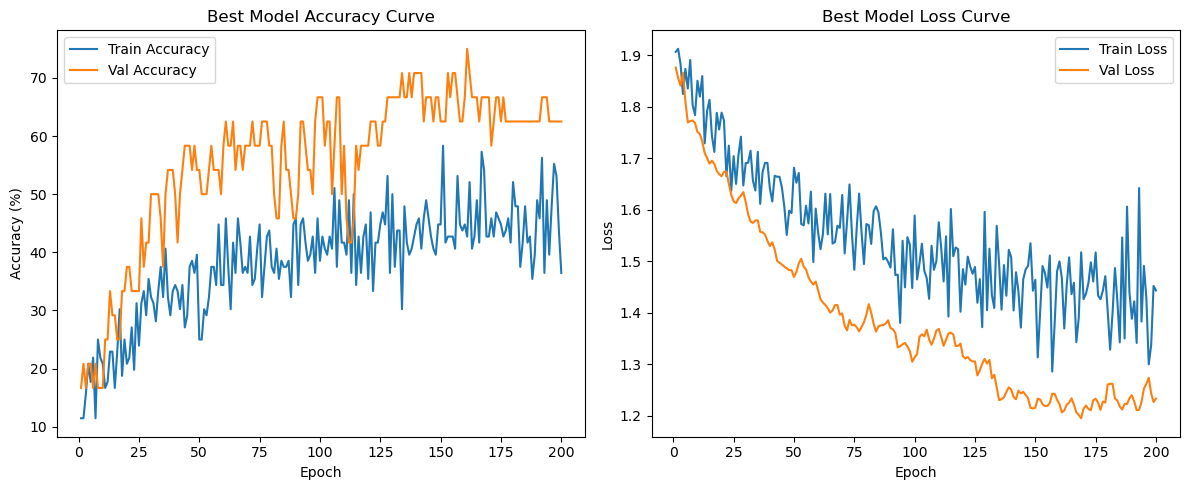

In [17]:
# Retrieve the metrics for the best experiment
for exp, metrics in results:
    if exp == best_exp:
        best_metrics = metrics
        break

# best_metrics: (train_losses, train_accs, val_losses, val_accs, best_val_acc)
train_losses, train_accs, val_losses, val_accs, best_val_acc = best_metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot accuracy curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Best Model Accuracy Curve')
plt.legend()

# Plot loss curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Best Model Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


## D. Evaluating Your Trained Model

In [18]:
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

resize_size = best_exp['resize_size']
batch_size = best_exp['batch_size']
normalize = best_exp['normalize']

norm_components = []
if normalize:
    # using arbitrary cifar-like mean/std; adjust as needed
    norm_components.append(transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)))

train_transforms = transforms.Compose(
        [
            transforms.Resize(resize_size),
            transforms.AutoAugment(),
            transforms.RandomRotation(25),
            transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ] + norm_components
    )

val_transforms = transforms.Compose(
    [
        transforms.Resize(resize_size),
        transforms.ToTensor(),
    ] + norm_components
)

# Custom Dataset class
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        if self.transform:
            new_x = self.transform(Image.fromarray(new_x))
        return new_x, self.y[idx]

train_dataset = MyDataset(x_train, y_train, transform=train_transforms)
val_dataset = MyDataset(x_val, y_val, transform=val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

### Load Trained Model and Evaluate

In [20]:
import torch
# Load the trained weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model.load_state_dict(torch.load('best_model.pth'))
model = new_model.to(device)

# Set the model to evaluation mode
model.eval()


test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.to(device)
        images = (images)

        labels = labels.to(device)
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([2, 3, 0, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 2, 3, 3, 4, 2, 4, 4, 5, 3, 5, 5],
       device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5],
       device='cuda:0')
Test accuracy is 75.0%


## COMPARE: Use ResNet18

In [22]:
# Define hyperparameters for the experiments
hyperparams = [
    {'batch_size': 32, 'resize_size': (512, 512), 'normalize': False},
]

results = []


best_val_acc_global = -1
best_model_state_dict = None
best_exp = None

for exp in hyperparams:
    print("Experiment:", exp)
    # New model with frozen parameters
    import torch.nn as nn
    from torchvision import models
    new_model = models.resnet18(weights='IMAGENET1K_V1')
    for param in new_model.parameters():
        param.requires_grad = False
    # change # of class from 1000 into 8 in the last layer
    num_ftrs = new_model.fc.in_features
    num_class = num_classes
    new_model.fc = nn.Linear(num_ftrs, num_class)
    
    # Train the model with the current hyperparameters
    current_epochs = exp.get('epochs', 200)
    model_result, metrics = train_model(x_train, y_train, x_val, y_val, new_model,
                                        batch_size=exp['batch_size'],
                                        resize_size=exp['resize_size'],
                                        normalize=exp['normalize'],
                                        epochs=current_epochs)
    results.append((exp, metrics))
    
    # metrics: (avg_train_loss, train_accuracy, avg_val_loss, val_accuracy, best_val_acc)
    _, _, _, _, best_val_acc = metrics
    if best_val_acc > best_val_acc_global:
        best_val_acc_global = best_val_acc
        best_exp = exp
        
# print the results of all experiments
print("\nSummary of Experiments:")
for exp, metrics in results:
    print("Hyperparameters:", exp)
    print("Results:")
    print("  avg_train_loss:", metrics[0][-1])
    print("  train_accuracy:", metrics[1][-1])
    print("  avg_val_loss:", metrics[2][-1])
    print("  val_accuracy:", metrics[3][-1])
    print("  best_val_acc:", metrics[4])

Experiment: {'batch_size': 32, 'resize_size': (512, 512), 'normalize': False}
Length of train_loader: 3
Length of val_loader: 1


  0%|          | 0/200 [00:00<?, ?it/s]


Summary of Experiments:
Hyperparameters: {'batch_size': 32, 'resize_size': (512, 512), 'normalize': False}
Results:
  avg_train_loss: 1.6547949314117432
  train_accuracy: 32.291666666666664
  avg_val_loss: 1.6818033456802368
  val_accuracy: 37.5
  best_val_acc: 45.833333333333336


<div align="center">

## Original Model

</div>

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]
    
batch_size = 32

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.resnet18(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = num_classes

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 50/200, Train loss: 1.7341, Train acc: 19.7917%, Val loss: 1.7685, Val acc: 25.0000%, Best Val loss: 1.7557 Best Val acc: 33.33%
Epoch 100/200, Train loss: 1.8037, Train acc: 22.9167%, Val loss: 1.8045, Val acc: 16.6667%, Best Val loss: 1.7462 Best Val acc: 33.33%
Epoch 150/200, Train loss: 1.7648, Train acc: 20.8333%, Val loss: 1.8095, Val acc: 16.6667%, Best Val loss: 1.7408 Best Val acc: 41.67%
Epoch 200/200, Train loss: 1.7297, Train acc: 23.9583%, Val loss: 1.7522, Val acc: 29.1667%, Best Val loss: 1.7344 Best Val acc: 41.67%


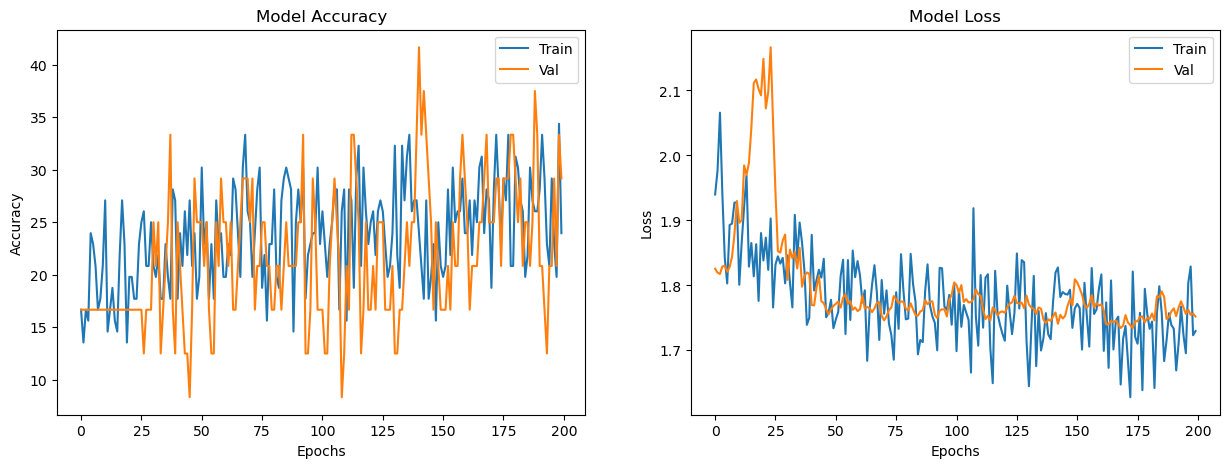

In [15]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 200
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.to(device)
        images = (images) / 255.
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            images = (images) / 255.
            labels = labels.to(device)
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()